ACO - Ant Colony Optimization ou Otimização da Colônia de Formigas é uma metaheurística proposta pelo pesquisador Marco Dorigo em 1992 para resolver problemas de otimização inspirado no comportamento das formigas ao saírem de sua colônia para encontrar comida, buscando a solução de problemas computacionais que envolvem procura de caminhos em grafos.

Dorigo, M.; Maniezzo, V.; Colorni, A. Ant system: optimization by a colony of cooperating agents. IEEE Transactions on Systems, Man, and Cybernetics (Volume: 26, Issue: 1). https://doi.org/10.1109/3477.484436, 1996.

Explicação do algoritmo: https://youtu.be/wi7zW_77pSE

In [1]:
# importa bibliotecas
try:
  import gdown
except ImportError:
  !pip install gdown
  import gdown
from numpy.random import choice
from scipy import spatial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from sklearn import metrics

In [21]:
# define os hiperparâmetros
DIMENSOES = 2 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos (episódios) especificando quantas explorações podem ser realizadas
COLONIA = 30 #tamanho da população correspondente ao número de formigas no formigueiro
FONTES_ALIMENTACAO = 10 #quantidade de pontos no grafo representando as coordenadas das dimensões do problema
E1 = 1000 #extremo esquerdo eixo x
E2 = 3000 #extremo direito eixo x
E3 = 0 #extremo inferior eixo y
E4 = 300 #extremo superior eixo y
LIMITES = [E1,E4] #(bound) determina os valores mínimos e máximos do espaço de busca
FCUSTO = 'caminho' #(fitness) define a aptidão da formiga na possível solução do problema
E = 0.2 #taxa de evaporação do feromônio nos caminhos
ALFA = 0.5 #coeficente de importância da qtde feromônio para determinar probabilidade de escolha do caminho
BETA = 0.7 #coeficente de importância do caminho para determinar a probabilidade de escolha do caminho

In [3]:
# Atribuir ID do arquivo no Google Drive
file_id = '1mJjL8QxDE9wqhqDrIe-Fm0lO9v5XNWQi'
dataset_url = f'https://drive.google.com/uc?id={file_id}'

# Definir nome do arquivo
output_path = 'rotas.csv'

# Baixar o arquivo usando gdown
gdown.download(dataset_url, output_path, quiet=False)

# Carregar o arquivo CSV em um DataFrame, especificando o separador como ponto-e-vírgula
dataset = pd.read_csv(output_path, sep=';')

Downloading...
From: https://drive.google.com/uc?id=1mJjL8QxDE9wqhqDrIe-Fm0lO9v5XNWQi
To: /content/rotas.csv
100%|██████████| 112k/112k [00:00<00:00, 38.4MB/s]


In [4]:
# Dados do dataset
print("Dados do dataset:")
print(dataset.head().to_string())

# Get information about the data types of each column
print("\nTipos de dados:")
print(dataset.info())

# Get descriptive statistics for numerical columns
print("\nEstatísticas:")
print(dataset.describe())

# Check for missing values
print("\nValores faltando:")
print(dataset.isnull().sum())

Dados do dataset:
  ROTAS  DISTANCIA  FALHAS  ACIDENTES  VELOCIDADE
0    R1       1590     200         40          80
1    R2       1310      30         10         120
2    R3       1410      20         30          80
3    R4       2690     130         10         120
4    R5       1820     270         40          80

Tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5119 entries, 0 to 5118
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROTAS       5119 non-null   object
 1   DISTANCIA   5119 non-null   int64 
 2   FALHAS      5119 non-null   int64 
 3   ACIDENTES   5119 non-null   int64 
 4   VELOCIDADE  5119 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 200.1+ KB
None

Estatísticas:
         DISTANCIA       FALHAS    ACIDENTES   VELOCIDADE
count  5119.000000  5119.000000  5119.000000  5119.000000
mean   2258.808361   150.093768    30.050791    99.917953
std    1010.991849    89.243439  

In [ ]:
# Remover linhas com valores nulos
dataset = dataset.dropna()

# Dados do dataset após a remoção de valores nulos
print("\nDados do dataset após a remoção de valores nulos:")
print(dataset.head().to_string())

# Verificar ocorrência de nulos
print("\nValores faltando (após remoção):")
print(dataset.isnull().sum())


Dados do dataset após a remoção de valores nulos:
  ROTAS  DISTANCIA  FALHAS  ACIDENTES  VELOCIDADE
0    R1       1590     200         40          80
1    R2       1310      30         10         120
2    R3       1410      20         30          80
3    R4       2690     130         10         120
4    R5       1820     270         40          80

Valores faltando (após remoção):
ROTAS         0
DISTANCIA     0
FALHAS        0
ACIDENTES     0
VELOCIDADE    0
dtype: int64


In [5]:
# Criar arrays para as colunas especificadas
rotas = dataset['ROTAS'].values
distancia = dataset['DISTANCIA'].values
falhas = dataset['FALHAS'].values
acidentes = dataset['ACIDENTES'].values
velocidade = dataset['VELOCIDADE'].values

# Exibir os primeiros elementos de cada array (opcional)
print("Rotas:", rotas[:COLONIA])
print("Distância:", distancia[:COLONIA])
print("Falhas:", falhas[:COLONIA])
print("Acidentes:", acidentes[:COLONIA])
print("Velocidade:", velocidade[:COLONIA])

Rotas: ['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'R12' 'R13'
 'R14' 'R15' 'R16' 'R17' 'R18' 'R19' 'R20' 'R21' 'R22' 'R23' 'R24' 'R25'
 'R26' 'R27' 'R28' 'R29' 'R30']
Distância: [1590 1310 1410 2690 1820 2250 2640 1480 2450 2030 2220 2030 2960 1680
 2010 2780 1820 2650 2420 1280 1410 1670 2190 2990 1140 1700 1810 2930
 2540 2020]
Falhas: [200  30  20 130 270 120 200 110 180  10 290 300 100 300 220 150 100 100
 120 140 100 280 190 180  80 300 200 180  70  30]
Acidentes: [40 10 30 10 40 50 20 40 20 40 30 40 30 30 30 20 50 10 50 50 30 50 40 20
 10 20 10 50 40 50]
Velocidade: [ 80 120  80 120  80 100 120 100 120  80  80  80 120 120 100 100 100 100
  80  80 120 100 100  80  80 120  80 100 100 120]


In [6]:
# função custo ou objetivo ou aptidão ou otimização ou fitness - usada para buscar o melhor ponto dentro de um espaço de buscao (melhor global) sem ficar preso em um melhor local
def fcusto(problema, possivel_solucao, alfa=0, beta=0, gama=0, delta=0, epsilon=0, zeta=0):
  total = 0.0
  if problema == 'rosenbrock':
    for i in range(DIMENSOES-1):
      total += 100*(possivel_solucao[i+1] - possivel_solucao[i]**2)**2 + (1-possivel_solucao[i])**2
  elif problema == 'esfera':
    for i in range(DIMENSOES):
      total += possivel_solucao[i]**2
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(sum([coord ** 2 for coord in possivel_solucao]))
  elif problema == 'caminho':
    denominador = sum([(caminho.feromonio)**ALFA * (1 / caminho.comprimento)**BETA for caminho in possivel_solucao])
    distribuicao_probabilidades = None
    if denominador == 0:
      distribuicao_probabilidades = [1 / len(possivel_solucao)  for _ in possivel_solucao]
    else:
      distribuicao_probabilidades = [((caminho.feromonio)**ALFA * (1 / caminho.comprimento)**BETA) / denominador for caminho in possivel_solucao]
    total = choice(possivel_solucao, 1, p=distribuicao_probabilidades)[0]
  elif problema == "distância":
    total = 0
    for i in range(COLONIA):
      if i < COLONIA - 1:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[i+1]])
      else:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[0]])
    total = 1/total
  else:
    print('Problema não encontrado!')
  return total

In [7]:
# formiga - unidade base da otimização, responsável por depositar o feromônio pelos caminhos que percorrem para indicar a qualidade do mesmo
class Formiga:
  def __init__(self, ponto_atual):
    self.ponto_atual = ponto_atual
    self.rota = [ponto_atual]
  def andar(self, ponto):
    self.ponto_atual = ponto
    self.rota.append(ponto)

In [8]:
# ponto - representação de uma coordenada no espaço
class Ponto:
  def __init__(self, x, y):
    self.x = x
    self.y = y

In [9]:
# caminho - ligação entre dois pontos
class Caminho:
  def __init__(self, ponto_i, ponto_j):
    self.ponto_i = ponto_i
    self.ponto_j = ponto_j
    self.comprimento = math.sqrt((ponto_i.x - ponto_j.x)**2 + (ponto_i.y - ponto_j.y)**2)
    self.feromonio = 0
    self.formigas_passantes = []
  def contem(self, formiga):
    if self.ponto_i == formiga.ponto_atual:
      return self.ponto_j not in formiga.rota
    elif self.ponto_j == formiga.ponto_atual:
      return self.ponto_i not in formiga.rota
    else:
      return False
  def ponto_adjacente(self, ponto):
    if self.ponto_i == ponto:
      return self.ponto_j
    elif self.ponto_j == ponto:
      return self.ponto_i
    else:
      return None

In [10]:
# grafo - representação de um conjunto de pontos ligados por caminhos
class Grafo:
  def __init__(self, caminhos):
    self.caminhos = caminhos
    self.melhor_rota = []
    self.comprimento_melhor_rota = 0
  def atualizas_melhor_rota(self, melhor_rota):
    self.melhor_rota = melhor_rota
    self.comprimento_melhor_rota = sum([math.sqrt((i.x - j.x)**2 + (i.y - j.y)**2) for [i, j] in melhor_rota])
  def possiveis_caminhos(self, formiga):
    return [caminho for caminho in self.caminhos if caminho.contem(formiga)]

In [11]:
# inicializa pontos - fontes de alimentação das formigas que correspondem dimensões do problema
pontos = []
for i in range(FONTES_ALIMENTACAO):
  dis = distancia[i]
  fal = falhas[i]
  pontos.append(Ponto(dis, fal))
print(distancia)
print(falhas)

[1590 1310 1410 ...  890 1970 1260]
[200  30  20 ... 180  30  80]


In [12]:
# inicializa caminhos
caminhos = []
i = 0
while i < FONTES_ALIMENTACAO - 1:
  j = i + 1
  while j < FONTES_ALIMENTACAO:
    caminhos.append(Caminho(pontos[i], pontos[j]))
    j += 1
  i += 1

In [13]:
# calcula rota (fitness)
def distancia_rota(rota):
  distancia_rota = 0
  for i in range(0, len(rota) - 1):
    distancia = math.sqrt((rota[i].x - rota[i + 1].x)**2 + (rota[i].y - rota[i + 1].y)**2)
    distancia_rota += distancia
  return distancia_rota

In [14]:
# calcula a atualização do feromônio
def atualizar_feromonios(caminhos):
  for caminho in caminhos:
    soma_heuristica = sum([1 / distancia_rota(formiga.rota) for formiga in caminho.formigas_passantes])
    caminho.feromonio = (1 - E) * caminho.feromonio + soma_heuristica
    caminho.formigas_passantes = []

In [15]:
# calcula o movimento das formigas
def movimentar_formiga(formiga, grafo):
  while True:
    possiveis_caminhos = grafo.possiveis_caminhos(formiga)
    if possiveis_caminhos == []:
      break
    caminho_escolhido = fcusto(FCUSTO,possiveis_caminhos)
    caminho_escolhido.formigas_passantes.append(formiga)
    formiga.andar(caminho_escolhido.ponto_adjacente(formiga.ponto_atual))

In [16]:
# plota posições no gráfico
def exibe_grafico(titulo,x,y,x_rota=[],y_rota=[]):
  plt.axis([E1,E2,E3,E4])
  for i in range(COLONIA):
    plt.plot(x, y, 'ro')
  plt.plot(0,0, marker='*', markersize=10, color='b')
  plt.plot(x,y, color='c', linewidth=0.2)
  if (len(x_rota)!=0):
    plt.plot(x_rota,y_rota, color='r', linewidth=0.6)
  plt.title(titulo)
  plt.show()

In [17]:
# inicializa população (colonia)
def inicializar_colonia():
  formigas = []
  for _ in range(COLONIA):
    formigas.append(Formiga(random.choice(pontos)))
  return formigas

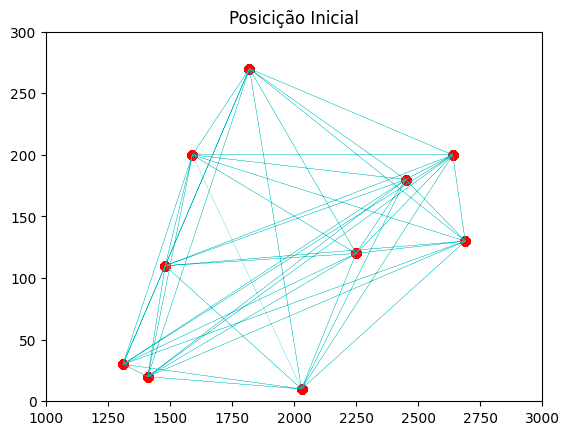

In [18]:
# posiciona as fontes de alimentação das formigas no espaço de busca
grafo = Grafo(caminhos)
x = []
y = []
for caminho in caminhos:
  x_i = caminho.ponto_i.x
  x_j = caminho.ponto_j.x
  y_i = caminho.ponto_i.y
  y_j = caminho.ponto_j.y
  x_texto = (x_i + x_j) / 2
  y_texto = (y_i + y_j) / 2
  x.append(x_i)
  x.append(x_j)
  y.append(y_i)
  y.append(y_j)
exibe_grafico('Posicição Inicial',x,y)
gx = x
gy = y

In [22]:
#otimização ACO
melhor_rota = None
distancia_melhor_sequencia = 0
lista_melhores_valores = []
convergencia = []
for _ in range(ITERACOES):
  print("Iteração: {:.0f}".format(_+1))
  formigas = inicializar_colonia()
  for formiga in formigas:
    movimentar_formiga(formiga, grafo)
    if melhor_rota is None or distancia_rota(melhor_rota) > distancia_rota(formiga.rota):
      melhor_rota = formiga.rota
      distancia_melhor_sequencia = distancia_rota(formiga.rota)
      lista_melhores_valores.append(distancia_melhor_sequencia)
  atualizar_feromonios(grafo.caminhos)
  x = []
  y = []
  for caminho in caminhos:
    x_i = caminho.ponto_i.x
    x_j = caminho.ponto_j.x
    y_i = caminho.ponto_i.y
    y_j = caminho.ponto_j.y
    x_texto = (x_i + x_j) / 2
    y_texto = (y_i + y_j) / 2
    x.append(x_i)
    x.append(x_j)
    y.append(y_i)
    y.append(y_j)
  x_rota = []
  y_rota = []
  for ponto in melhor_rota:
    x_rota.append(ponto.x)
    y_rota.append(ponto.y)
  exibe_grafico('Melhor Solução: {:.5f}'.format(distancia_melhor_sequencia),x,y,x_rota,y_rota)
  convergencia.append(distancia_melhor_sequencia)

Output hidden; open in https://colab.research.google.com to view.

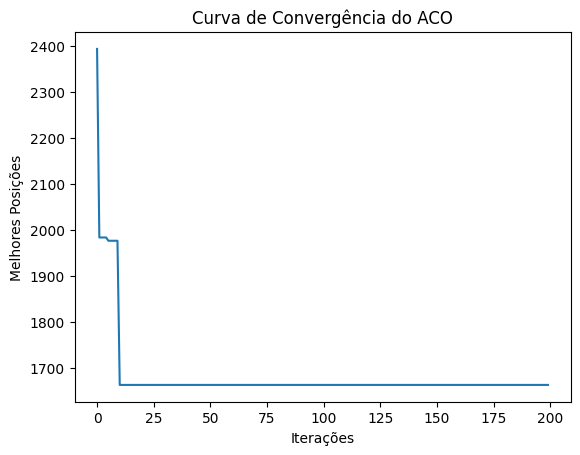

In [23]:
#exibe curva de convergência das formigas
x = []
y = []
for i in range(ITERACOES):
  x.append(i)
  y.append(convergencia[i])
plt.title("Curva de Convergência do ACO")
plt.xlabel("Iterações")
plt.ylabel("Melhores Posições")
plt.plot(x,y)
plt.show()

In [24]:
for i in range(ITERACOES): print("iteração:",i,"posição:",convergencia[i])

iteração: 0 posição: 2394.1598228615417
iteração: 1 posição: 1983.9110618258353
iteração: 2 posição: 1983.9110618258353
iteração: 3 posição: 1983.9110618258353
iteração: 4 posição: 1983.9110618258353
iteração: 5 posição: 1976.7787821294162
iteração: 6 posição: 1976.7787821294162
iteração: 7 posição: 1976.7787821294162
iteração: 8 posição: 1976.7787821294162
iteração: 9 posição: 1976.7787821294162
iteração: 10 posição: 1663.121399820478
iteração: 11 posição: 1663.121399820478
iteração: 12 posição: 1663.121399820478
iteração: 13 posição: 1663.121399820478
iteração: 14 posição: 1663.121399820478
iteração: 15 posição: 1663.121399820478
iteração: 16 posição: 1663.121399820478
iteração: 17 posição: 1663.121399820478
iteração: 18 posição: 1663.121399820478
iteração: 19 posição: 1663.121399820478
iteração: 20 posição: 1663.121399820478
iteração: 21 posição: 1663.121399820478
iteração: 22 posição: 1663.121399820478
iteração: 23 posição: 1663.121399820478
iteração: 24 posição: 1663.121399820478
